# Evaluaciones de performance

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

seed_value = 32
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

train_dir = "data/spectrograms/speech"
test_dir = "data/spectrograms_test/speech"

img_width, img_height = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.125,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = tf.keras.preprocessing.image.DirectoryIterator(
    directory=train_dir,
    image_data_generator=train_datagen,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

def create_cnn_x_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(8, (3, 3), activation='relu')(inputs)
    x = AveragePooling2D((2, 2))(x)
    
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = AveragePooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = AveragePooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)  
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (img_width, img_height, 3)
num_classes = 8
learning_rate = 0.0001  
momentum = 0.8
epochs = 50  

model = create_cnn_x_model(input_shape, num_classes)

optimizer = RMSprop(learning_rate=learning_rate, momentum=momentum)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Found 67 images belonging to 1 classes.
Found 947 images belonging to 7 classes.
Found 1014 images belonging to 8 classes.
Found 142 images belonging to 8 classes.
Found 300 images belonging to 8 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 111, 111, 8)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 54, 54, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 26, 26, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │    44,304,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,523,160 (185.10 MB)

 Trainable params: 48,523,160 (185.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 700ms/step - accuracy: 0.1459 - loss: 2.0721 - val_accuracy: 0.1328 - val_loss: 2.0614
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1250 - loss: 2.0374 - val_accuracy: 0.3571 - val_loss: 2.0476
Epoch 3/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 701ms/step - accuracy: 0.1497 - loss: 2.0461 - val_accuracy: 0.2500 - val_loss: 1.9770
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0938 - loss: 2.1512 - val_accuracy: 0.2143 - val_loss: 1.9420
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 686ms/step - accuracy: 0.2663 - loss: 1.9073 - val_accuracy: 0.3516 - val_loss: 1.8451
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3125 - loss: 1.8395 - val_accuracy: 0.2857 - val_loss: 1.9037
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 661ms/step - accuracy: 0.2919 - loss: 1.7756 - val_accuracy: 0.3984 - val_loss: 1.7496
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3125 - loss: 1.7486 - val_accuracy: 0.1429 - val_loss: 2.1566
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - accuracy: 0.3387 - loss: 1.7180 - val_accuracy: 0.3125 - val_loss: 1.7435
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4375 - loss: 1.5684 - val_accuracy: 0.5000 - val_los

# Exploración de los datos

Se hace un histograma de las emociones del dataset.

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dir_path = "data"
emotions = {
    "01": "neutral",
    "02": "calma",
    "03": "feliz",
    "04": "triste",
    "05": "enojado",
    "06": "temeroso",
    "07": "disgustado",
    "08": "sorprendido"
}

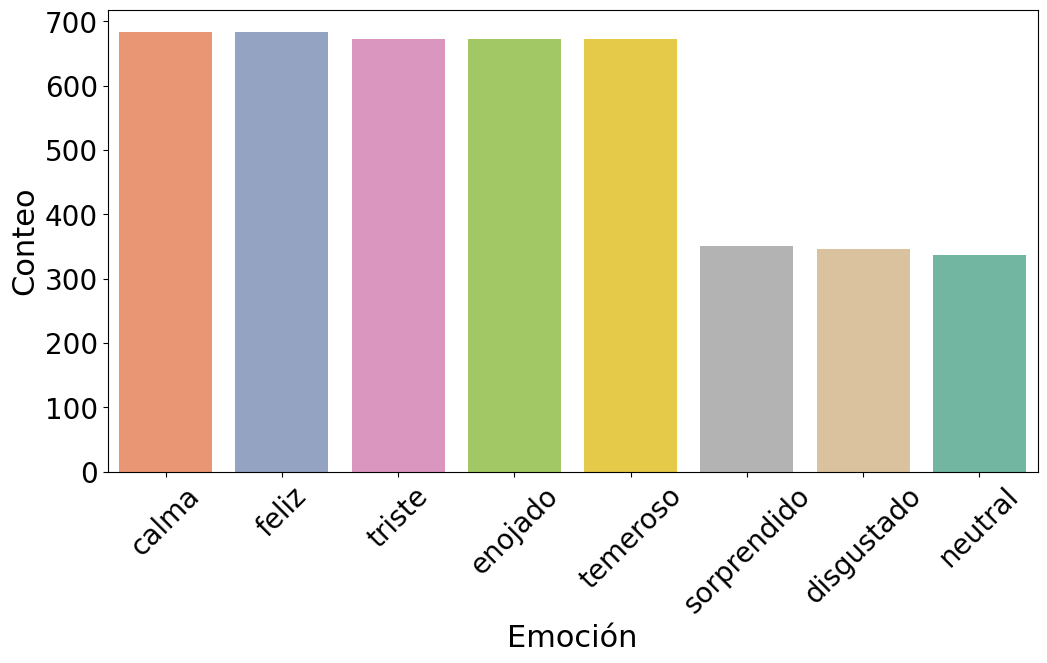

In [ ]:
emotion_list = []

for root, dirs, files in os.walk(dir_path):
    for file in files:
        if file.endswith('.wav'):
            emotion_code = file.split('-')[2]
            emotion = emotions[emotion_code]
            emotion_list.append(emotion)

df = pd.DataFrame(emotion_list, columns=["Emoción"])

plt.figure(figsize=(12, 6))
sns.countplot(x="Emoción", data=df, order=df["Emoción"].value_counts().index, hue="Emoción", palette="Set2", legend=False)
plt.xlabel("Emoción", fontsize=22)
plt.ylabel("Conteo", fontsize=22)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.show()
# plt.tight_layout()
# plt.savefig("clases_desbalanceadas_todo.pdf")